In [7]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import yfinance as yf

In [8]:
tickers = ["PFE", "JNJ", "GOOGL", 
           "AAPL", "COST", "WMT", "KR", "JPM", 
          "BAC", "HSBC"]
tickers.sort()
df = yf.download(tickers, start ='2016-01-01', end ='2019-12-30')
df = df.loc[:,('Adj Close', slice(None))]
df.columns = tickers
assets = df.pct_change().dropna()

[*********************100%***********************]  10 of 10 completed


In [9]:
df1 = df

In [10]:
df2 = df1.pct_change()
df=df2.iloc[1:len(df2.index),:]
r = np.mean(df,axis=0)*252
covar = df.cov()

In [11]:
def ret(r,w):
    return r.dot(w)
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret,vol):
    return ret/vol

In [12]:
from scipy.optimize import Bounds
bounds = Bounds(0, 1)

from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint(np.ones((df2.shape[1],), dtype=int),1,1)

# Find a portfolio with the minimum risk.
from scipy.optimize import minimize
#Create x0, the first guess at the values of each stock's weight.
weights = np.ones(df2.shape[1])
x0 = weights/np.sum(weights)
#Define a function to calculate volatility
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

np.set_printoptions(suppress = True, precision=2)
print(w_min)
print('return: % .2f'% (ret(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar))

[0.02 0.   0.11 0.04 0.21 0.26 0.   0.04 0.16 0.16]
return:  13.61 risk:  0.007


In [13]:
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
w_sharpe = res_sharpe.x
print(w_sharpe)
print('return: % .2f'% (ret(r,w_sharpe)*100), 'risk: % .3f'% vol(w_sharpe,covar))

[0.25 0.   0.11 0.   0.   0.1  0.25 0.   0.   0.29]
return:  23.16 risk:  0.009


[18.39 19.47 20.5  21.47 22.38 23.2  23.94 24.61 25.19 25.68 26.05 26.23
 26.24 26.12 25.82 25.28 24.35 23.25 22.05 20.86]
-------
[0.74 0.74 0.74 0.75 0.76 0.76 0.78 0.79 0.8  0.82 0.84 0.86 0.9  0.93
 0.97 1.03 1.1  1.19 1.29 1.4 ]
-------
[0.14 0.14 0.15 0.16 0.17 0.18 0.19 0.19 0.2  0.21 0.22 0.23 0.24 0.24
 0.25 0.26 0.27 0.28 0.28 0.29]


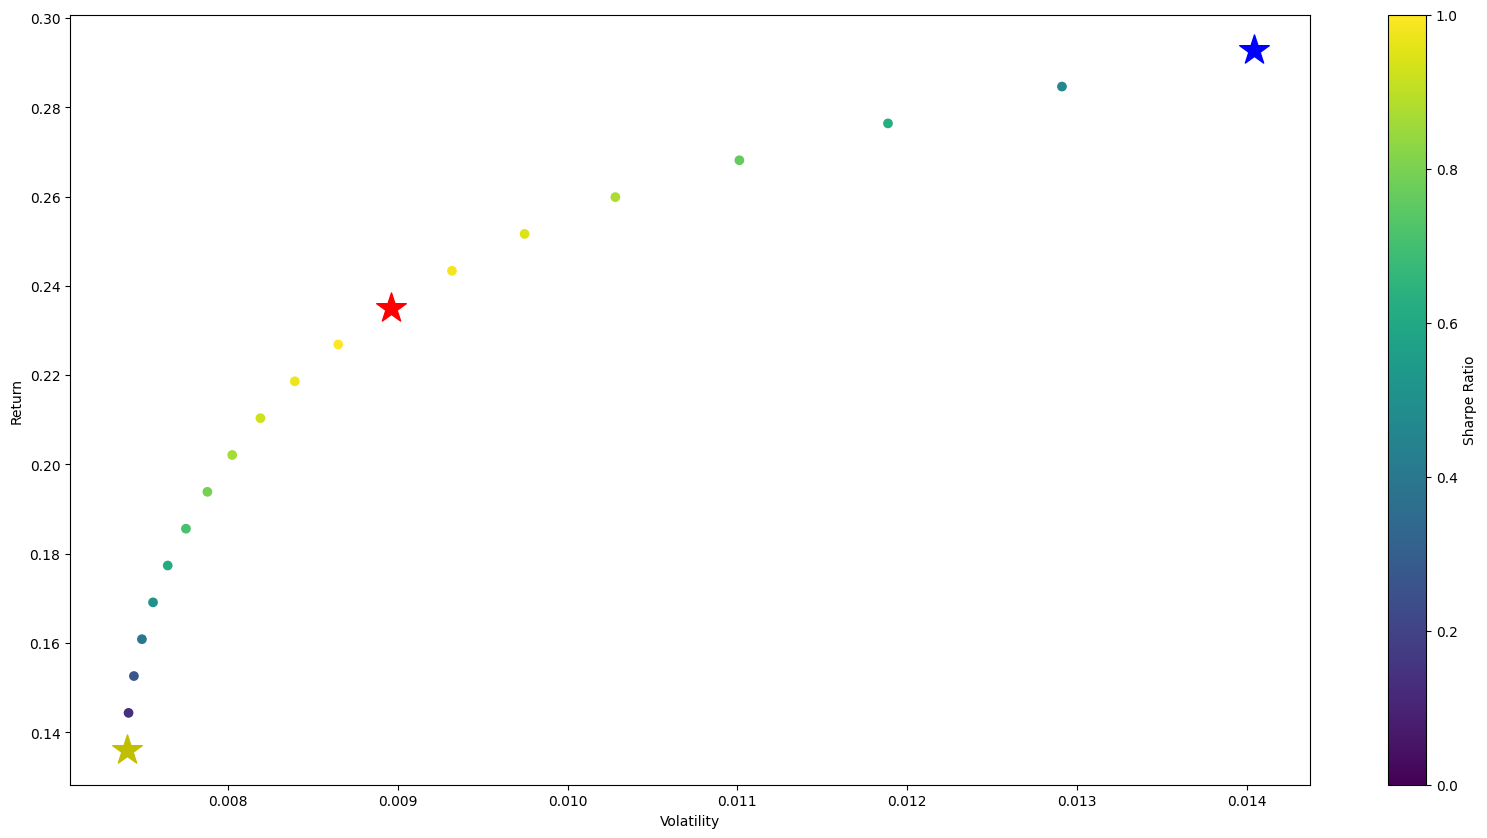

In [25]:
w = w_min
num_ports = 20
gap = (np.amax(r) - ret(r,w_min))/num_ports
all_weights = np.zeros((num_ports, len(df.columns)))
all_weights[0],all_weights[1]=w_min,w_sharpe
ret_arr = np.zeros(num_ports)
ret_arr[0],ret_arr[1]=ret(r,w_min),ret(r,w_sharpe)
vol_arr = np.zeros(num_ports)
vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)
for i in range(num_ports):
    port_ret = ret(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(df2.shape[1]),r],[1,port_ret],[1,port_ret])
    x0 = w_min
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)
    all_weights[i,:]=a.x
    ret_arr[i]=port_ret
    vol_arr[i]=vol(a.x,covar)   
sharpe_arr = ret_arr/vol_arr
print(sharpe_arr)
print('-------')
print(vol_arr * 100)
print('-------')
print(ret_arr)
plt.figure(figsize=(20,10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.scatter(vol_arr[0], ret_arr[0], color='y',marker='*',s=500)
plt.scatter(vol_arr[12], ret_arr[12], color='r',marker='*',s=500)
plt.scatter(vol_arr[-1], ret_arr[-1], color='b',marker='*',s=500)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()


In [15]:
print(type(plt))

<class 'module'>
